# <span style='color:deepskyblue'> Cosmology MCMC notebook </span>

## <span style='color:deepskyblue'>Preliminaries</span>

In [52]:
# Install required packages (if not available on server)
!pip install getdist
import numpy as np
import matplotlib.pyplot as plt

## <span style='color:deepskyblue'> The $\Lambda$ CDM Model </span>

The Lambda-Cold-Dark-Matter ($\Lambda$ CDM) Model is our concordance cosmological model. It postulates a Universe that behaves according to **General Relativity**, filled with **baryons** (protons, neutrons - the stuff we and stars are made of!), **Cold Dark Matter (CDM)** and a **Cosmological Constant** $\Lambda$.

The expansion of the Universe is best described in terms of the **scale factor** $a$ (the "radius" of the Universe, conventionally set to 1 today) and the **Hubble rate** $H$

$$
H \equiv \frac{\dot a}{a}
$$

The Einstein Equations in a **homogeneous, isotropic** Universe have an especially simple form and a special name, **Friedmann Equation**:

$$
H^2 = \frac{8\pi G}{3}\rho + \frac{k}{a^2}
$$

where $\rho$ is the total energy density of the Universe (at a certain time or size), and $k$ is a universal constant related to the [spatial curvature and shape of the Universe](https://en.wikipedia.org/wiki/Shape_of_the_universe#:~:text=The%20spatial%20curvature%20is%20related,indistinguishable%20spaces%20with%20different%20topologies.). In the $\Lambda$CDM model, this additionally simplifies to

$$
\boxed{
H^2 = H_0^2\left(\Omega_\Lambda + \Omega_m a^{-3} + \Omega_k a^{-2}\right)
}
\qquad
\qquad
\Omega_m + \Omega_\Lambda + \Omega_k = 1
$$

$H_0$ is the value of the Hubble rate *today*, and the parameters $\Omega_m$, $\Omega_\Lambda$ and $\Omega_k$ are dimensionless quantities indicating how much of the present expansion of the Universe is due to (non-relativistic) matter, cosmological constant $\Lambda$, and spatial curvature $k$. Note that the three $\Omega$'s are *not independent* (their sum is 1) and that we grouped together the contribution of baryons and CDM,

$$
\Omega_m = \Omega_{\rm CDM} + \Omega_{\rm b}
$$

and that we have evidence that independent evidence that $\Omega_b \approx 5$\%. Note that only $\Omega_m \geq 0$ makes physical sense, while in principle both $\Omega_\Lambda$ and $\Omega_k$ can be negative.

The present Hubble rate is conventionally parametrised in terms of the dimensionless $h$:

$$
H_0 \equiv h\,\frac{100 \text{km}}{\text{s Mpc}}
$$

where Mpc = Megaparsec and [parsec](https://en.wikipedia.org/wiki/Parsec) equals to about $3.26$ light years or $3.086 \cdot 10^{16}$ m. 

In essence, these equations give us the relation between *what exists in the Universe* and *how the Universe expanded*. Measure one, I can tell you the other. This is precisely what we aim to do!

Time to define the function $H(z)$. Don't forget to include the useful parameters as arguments of the function, and to define `parsec`.

In [53]:
PARSEC = 3.086e16 # m. not really needed anywhere

"""
H returns a function that takes one argument (z: red shift) and outputs the Hubble rate (km/s/Mpc) corresponding to H0, omega_lambda, omega_m, and z 
    H0 (float)              : present Hubble rate (km/s/Mpc)
    omega_lambda (float)    : omega lambda (unitless)
    omega_m (float)         : omega mass (unitless)
"""
def H(H0, omega_lambda, omega_m): 
    omega_k = 1 - omega_lambda - omega_m
    return lambda z : H0 * (omega_lambda + omega_m*(1+z)**3 + omega_k*(1+z)**2)**(1/2)


##  <span style='color:deepskyblue'>Supernovae Ia</span>

In order to track the expansion of the Universe, we will look at Supernovae type Ia observations. SNIa are formed when a *white dwarf* accretes matter from a companion until it reaches a critical mass of about $1.44 M_\odot$ (solar masses), after which it explodes **at always the same luminosity** $L_{\rm SN}$. Therefore, the observed [magnitude](https://en.wikipedia.org/wiki/Magnitude_(astronomy)) is only a function of their [**luminosity distance**](https://en.wikipedia.org/wiki/Distance_measures_(cosmology)) from Earth, defined as the ratio of the intrinsic luminosity $L_{\rm SNIa}$ and the measured *surface brightness* $\Phi$ (energy per unit time per unit area)

$$ d_L\equiv \frac{L_{\rm SN}}{4\pi \Phi} $$

While photons (light rays) travel from the distant SNIa to Earth, the Universe expands and the photons get redshifted, and this redshift is directly related to the size of the Universe when the photon was emitted compared to today:

$$ \frac{\lambda_{\rm obs}}{\lambda_{\rm em}} \equiv 1 + z_{\rm em} = \frac{1}{a_{\rm em}}$$

We can express the luminosity distance in terms of the Hubble rate:

$$ 
\boxed{
d_L(z) = \frac{c}{H_0}(1+z) \times 
\begin{cases}
    \cfrac{1}{\sqrt{\Omega_k}} \sinh\left(\sqrt{\Omega_k}D(z)\right) & \Omega_k > 0
    \\[.5em]
    D(z) & \Omega_k = 0
    \\[.5em]
    \cfrac{1}{\sqrt{-\Omega_k}} \sin\left(\sqrt{-\Omega_k}D(z)\right) & \Omega_k < 0
\end{cases}
\qquad\qquad
D(z) \equiv H_0\int_0^z \frac{{\rm d}Z}{H(Z)}
}
$$

where $c$ is the speed of light: $c \simeq 2.998 \cdot 10^{5}$ km/s.

Clearly, there exists a relation between $d_L(z)$ and $H(z)$, so the luminosity distance is a useful measure of the Universe expansion history.

We can create the function `dL(z, h, Omega_m, Omega_L)`. You can also pass the function `Hubble` as an argument: `dL(z, Hubble, Omega_m, Omega_Lambda)`. Additionally, you can create $D(z)$ for your convenience.

Note that you need to integrate the function $H(z)$, so write your own quick-and-easy numerical integrator or [look up the pre-written methods](https://docs.scipy.org/doc/scipy/reference/tutorial/integrate.html). Make sure it returns $d_L$ in parsecs and that it uses $H_0$ measured in km/s/Mpc!

In [54]:
c = 2.998e5 # km/s
import scipy.integrate as integrate


"""
D returns H0 times the integral of dZ/H_function(Z) from 0 to z_max
    z_max (float) : upper bound of integration
    H0 (float)    : present Hubble rate
    H_function (function) : function that takes a redshift and returns its corresponding Hubble rate
"""
def D(z_max, H0, H_function):
    return H0 * integrate.quad(lambda z : 1/H_function(z), 0, z_max)[0]



"""
dL returns a function that yields the luminosity distance (Mpc) corresponding to a certain redshift (z)
    same arguments as H
"""
def dL(H0, omega_lambda, omega_m):
    omega_k = 1 - omega_lambda - omega_m
    H_function = H(H0, omega_lambda, omega_m)

    if omega_k < 0:
        return lambda z: c*(1+z)/H0 * abs(omega_k)**(-1/2) * np.sin(abs(omega_k)**(1/2) * D(z, H0, H_function))
    
    if omega_k > 0:
        return lambda z: c*(1+z)/H0 * abs(omega_k)**(-1/2) * np.sinh(abs(omega_k)**(1/2) * D(z, H0, H_function))
    
    return lambda z: c*(1+z)/H0 * D(z, H0, H_function)


"""
dL_modulus returns a function that yields the luminosity distance modulus (unitless) corresponding to a certain redshift (z)
    same arguments as H
"""
def dL_modulus(H0, omega_lambda, omega_m):
    return lambda z: 5 * np.log10(dL(H0, omega_lambda, omega_m)(z) / 10 * 1e6)      # multiply result of dL() by 1e6 to convert from Mpc to pc





## <span style='color:deepskyblue'>The Union2.1 Compilation</span>

Our source of data is from [Union2.1](http://supernova.lbl.gov/Union/). It is a collection of $580$ SNIa, each observation is comprised of redshift $z$ and [distance modulus](https://en.wikipedia.org/wiki/Distance_modulus) $\mu$ (and corresponding errors $\delta\mu$), defined as the difference between the *apparent magnitude* $m$ and the *absolute magnitude* $M$:

$$
\boxed{
\mu(z) \equiv m(z) - M \equiv 5 \log_{10} \frac{d_L(z)}{10\,\text{pc}}
}
$$

Our goal today is to use SNIa measurements to constrain the parameters ($h, \Omega_\Lambda, \Omega_m$).

In essence, we can calculate for each redshift the theoretical value of $\mu$ using this equation with the expression for $d_L(z)$ and our model of choice $H(z)$ -- note that we will need to perform a numerical integral! -- and compare this value with observations. A different model would amount to changing the theoretical value of $H(z)$.

Let us start by importing and plotting the data:

In [55]:
dataloc = "http://supernova.lbl.gov/Union/figures/SCPUnion2.1_mu_vs_z.txt"

# Read in data as numpy array.
# Format is [name, redshift, magnitude, magnitude error, and another number?]
data = np.genfromtxt(dataloc)

# Print the first line as an example. (Note that genfromtxt turns the names into 'Not A Number')
print(data[0])

[           nan 2.84880000e-02 3.53465834e+01 2.23905933e-01
 1.28418942e-01]


In [56]:
# pull out the redshifts (zs), distance modulus (dist_mod) and magnitude estimated errors (err_dist_mod)
zs = data.T[1] # redshift
dist_mod = data.T[2] # distance modulus
err_dist_mod = data.T[3] # errors on distance modulus

In [57]:
# Let's look at the data, just for fun. 
# We can look both at the raw data (distance modulus) or calculate the luminosity distance
# Note that Numpy allows us to manipulate whole arrays at once

# luminosity distance in pc
dpc = 10. * 10.**(dist_mod / 5.)

# and in Mpc
dMpc = dpc / 10.**6

# and the error on that distance:
dMe = 10. * (10.**((dist_mod + err_dist_mod)/5.-6.) - 10.**((dist_mod - err_dist_mod)/5.-6.))

# check that function dL and dL_modulus work correctly
zsort = np.array(sorted(zs))
theory_dL = np.array([dL(70, 0.7, 0.3)(z) for z in zsort])
theory_dL_modulus = np.array([dL_modulus(70, 0.7, 0.3)(z) for z in zsort])

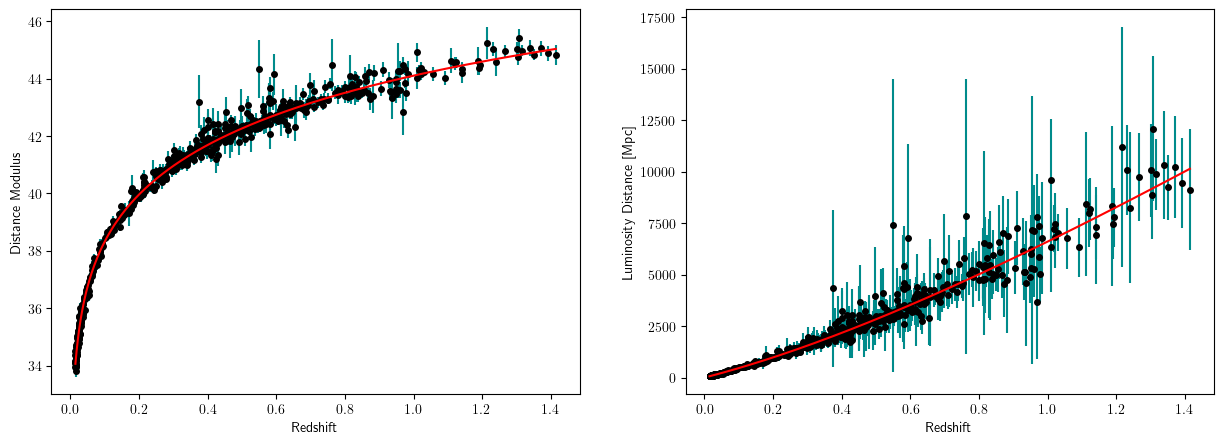

In [58]:
plt.subplots(1, 2, figsize=(15, 5))

# Plot distance modulus versus redshift (original data)
plt.subplot(1, 2, 1)
plt.xlabel("Redshift")
plt.ylabel("Distance Modulus")
plt.errorbar(zs, dist_mod, yerr=err_dist_mod, fmt='o', color='black', ecolor='darkcyan', markersize=4)
plt.plot(zsort, theory_dL_modulus, color='red', zorder=2.5)     # zorder argument tells plt to plot this graph above the data points

# Plot luminosity distance versus redshift
plt.subplot(1, 2, 2)
plt.xlabel("Redshift")
plt.ylabel("Luminosity Distance [Mpc]")
plt.errorbar(zs, dMpc, yerr=dMe, fmt='o', color='black', ecolor='darkcyan', markersize=4)
plt.plot(zsort, theory_dL, color='red', zorder=2.5)             # zorder argument tells plt to plot this graph above the data points
plt.show()

## <span style='color:deepskyblue'>Bayes' Theorem: Likelihood, Prior, Posterior (and Evidence...)</span>

The **conditional probability of A given that B is true** is denoted with $P(A|B)$ (read: *probability of A given B*). 
Did A happen? Then B has probability $P(B|A)$ of happening.

[**Bayes' Theorem**](https://en.wikipedia.org/wiki/Bayes%27_theorem) is simply a reflection of the symmetry of the concept of joint probability:

$$
P(A|B)P(B) = P(B|A)P(A)
$$

In physics, our goal is often to determine how likely the values of some parameters $\theta$ are, given how well they reproduce the data $D$. 
We write Bayes' theorem in the following equivalent form:

$$
P(\theta | D) = \frac{P(D|\theta)P(\theta)}{P(D)}
$$

The various terms conventionally take the names:

$$
\begin{aligned}
P(\theta | D) & && \text{Posterior}
\\
P(D | \theta)& && \text{Likelihood}
\\
P(\theta) & && \text{Prior}
\\
P(D) & && \text{Evidence}
\end{aligned}
$$

### <span style='color:deepskyblue'>Prior</span>

The *prior* quantifies our degree of prior belief in the model parameters. It can contain the results of previous experiments, or theoretical considerations (for instance, that certain parameters cannot be negative, etc.). 

We can have *strong priors* about something - the Sun still existing at night, see the comic below - or not.
When we do *not* have compelling prior knowledge about a parameter, we generally use a *non-informative* prior probability distribution, most often related to the [uniform distribution](https://en.wikipedia.org/wiki/Continuous_uniform_distribution)

$$
\begin{aligned}
    \text{Uniform} & && \theta \in \text{Uniform}[\theta_{\rm min}, \theta_{\rm max}]
    \\
    \text{Log Uniform} & && \log\theta \in \text{Uniform}[\log\theta_{\rm min}, \log\theta_{\rm max}]
\end{aligned}
$$

You may sometimes hear that "the prior doesn't matter". While this is not strictly true, it is however true that in many instances the *likelihood* depends more dramatically on the parameters and will have a dominating contribution to the posterior. You are more than welcome to try different priors for the model parameters and see if and how your results change.

### <span style='color:deepskyblue'>Likelihood</span>

The measure of how well our model reproduces the data is the **likelihood** $\mathcal L$. For normal (=Gaussian), uncorrelated data $\mu_i$ with errors $\sigma_i$ ($i = \{1,580\}$), the likelihood is related to the famous [**chi-squared**](https://en.wikipedia.org/wiki/Chi-square_distribution) via

$$
P(D | \theta) \equiv \mathcal L = \exp\left(-\frac{\chi^2}{2}\right)
\qquad
\qquad
\boxed{
\chi^2 \equiv \sum_{i=1}^{580} \frac{\left(\mu_i^{(\rm theor)} - \mu_i^{(\rm obs)}\right)^2}{\sigma_i^2}
}
$$

A *high likelihood* corresponds to a *low chi squared*.

In principle, we could attack the problem brute-force: create a grid of values for $h$, $\Omega_m$, $\Omega_\Lambda$, calculate the likelihood for each combination, and create a profile for the likelihood. 

In practical cases, however, this is not only sub-optimal but sometimes **impossible**. Think of complicated models with 20+ free parameters (this is not that unusual in physics, by the way). Even a very coarse grained grid of 100 values for each parameter would result in more than$10^{40}$ (!!!) different parameter combination to be tested. You can probably understand why this is undesirable.

### <span style='color:deepskyblue'>Evidence</span>

This is the tricky bit. The evidence, which is "*the probability of observing certain data*", is not something that is easy to evaluate or interpret. This looks like a serious limitation to finding the:


### <span style='color:deepskyblue'>Posterior</span>

What does the data tell us about the model parameters? The answer is the *posterior probability distribution*, often (but not necessarily) expressed as (average $\pm$ standard deviation)

$$
\theta_i = \bar\theta_i \pm \sigma_i
$$

In other words, the posterior tells us how likely it is for the model parameters to have certain values, *given that we observe the data* $D$.

*This is the final goal of our analysis!*

<br>

![title](http://1.bp.blogspot.com/-tTx4HDejSww/ULcTeK9_V_I/AAAAAAAAA8g/PCYOH-eXGbk/s1600/frequentists_vs_bayesians.png)
![title](https://i.redd.it/5r0hwixt0m931.jpg)

## <span style='color:deepskyblue'>Markov-Chain Monte Carlo</span>

Markov-Chain Monte Carlo techniques are a class of methods to sample a probability distribution $P(x)$ - in our case $P(\theta | D)$ - provided that we can calculate a density $\mathcal F(x)$ **that is proportional to it** - in our case $P(\theta)P(D|\theta)$ = likelihood $\times$ prior. Among these, a very popular one is the [**Metropolis-Hastings**](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm) algorithm, which is what we will use.

Schematically, the algorithm works as follows:
* Start with an $n$-tuple of parameters $\theta_{\rm old} = \{\theta_1, \theta_2, \dots\}_{\rm old}$ (in our case $\theta = \{h,\Omega_m,\Omega_\Lambda\}$) and calculate the $\mathcal F_{\rm old}$
* Propose a new set of parameters $\theta_{\rm prop}$, calculate the new corresponding $\mathcal F_{\rm prop}$. How you propose the new parameters is not essential as long as the probability of going from one set of parameters to the next is the same as the inverse: $P(\theta_a \to \theta_b) = P(\theta_b \to \theta_a)$. For this, we normally take Gaussian displacements with some (relatively small) standard deviation.
* Compare the new and old likelihoods-priors:
    * If $\mathcal F_{\rm prop} > \mathcal F_{\rm old}$, accept the step: $\theta_{\rm new} = \theta_{\rm prop}$
    * Otherwise, accept with probability $P_{\rm accept} = \mathcal F_{\rm prop}/\mathcal F_{\rm old}$
* If accepted, $\theta_{\rm new} = \theta_{\rm prop}$ and record the step; otherwise, $\theta_{\rm new} = \theta_{\rm old}$ (no re-recording)
* Update $\theta_{\rm old} = \theta_{\rm new}$
* Repeat

The MC chain keeps going until the desired number of steps or, ideally, when a suitable convergence test, like for example the [Gelman-Rubin test](https://bookdown.org/rdpeng/advstatcomp/monitoring-convergence.html), is satisfied. 
Today we will just set a limit to the total number of steps, but please feel free to implement and test your favourite convergence test!

Looking at equation (4), you can convince yourself that
$$
\frac{\mathcal L_a}{\mathcal L_b} = \exp\left(\frac{\chi_b^2 - \chi_a^2}{2}\right)
$$

(This is useful because $\chi^2$ can be large, so we want to avoid the likelihoods evaluating to `0.` -- computers don't like dividing by zero, unfortunately)
 
* Start with an $n$-tuple of parameters $\theta_{\rm old} = \{\theta_1, \theta_2, \dots\}_{\rm old}$ (in our case $\theta = \{h,\Omega_m,\Omega_\Lambda\}$) and the corresponding chi squared $\chi_{\rm old}^2$ (to be clear, for us this implies calculating a series of 580 integrals and comparing each with the observed values)
* Propose new parameters $\theta_{\rm prop}$ and calculate the corresponding chi squared $\chi_{\rm prop}^2$
* Draw a random number $r \in [0,1]$
* Accept the step if 
$$
r < \exp\left(\frac{\chi_{\rm old}^2 - \chi_{\rm prop}^2}{2}\right) \frac{P(\theta)_{\rm prop}}{P(\theta)_{\rm old}}
$$
* If accepted, update $\theta_{\rm old} = \theta_{\rm prop}$, and record; otherwise, $\theta_{\rm new} = \theta_{\rm old}$ (no re-recording)
* Repeat

In [59]:
"""
chi_sq returns the chi squared value of a model on some data
    model (function) : function that predicts y values for given x values
    xs (numpy array) : recorded x data
    ys (numpy array) : recorded y data
    y_errors (numpy array) : errors for y data
"""
def chi_sq(model, xs, ys, y_errors):
    predicted_ys = np.array([model(x) for x in xs])
    return sum((ys - predicted_ys)**2 / y_errors**2)            # from given formula



"""
F returns (likelihood x prior) for a model on some data
    same arguments as chi_sq
"""
def F(model, xs, ys, y_errors):
    likelihood = np.exp(-chi_sq(model, xs, ys, y_errors)/2)     # from given formula
    prior = 1                                                   # temporary value
    return likelihood * prior



"""
prop returns a list of proposed parameters
    params (list) : list of previous parameters
"""
def prop(params):
    prop_params = []
    stdevs = [0.1, 0.01, 0.01]                                          # standard deviation used on the normal distribution (the one for H0 is higher because the value is higher)
    for i in range(len(params)):
        prop_params += [np.random.normal(params[i], stdevs[i])]             # sample from a normal distribution centered around the previous parameter
        while prop_params[i] <= 0:                                          # keep generating propositions until one is positive
            prop_params[i] = np.random.normal(params[i], stdevs[i])         # replace proposition
            
    return prop_params


"""
Gelman_Rubin returns the Gelman-Rubin statistic of a list of markov chains
    chains (2D list) : list of chains (must all be the same length!)
    D (int)          : number of values that must be burnt in for every chain
"""
def Gelman_Rubin(chains, D):
    L = len(chains[0]) - D
    new_chains = [[chain[i] for i in range(D, L+D)] for chain in chains]    # burn first D elements of every chain
    
    chain_means = [np.mean(chain) for chain in new_chains]                  # compute the mean of every (new) chain
    B = np.var(chain_means, ddof=1)                                         # (sample) variance between chains => setting ddof (degrees of freedom) = 1 ensures 
    wc_var = [np.var(chain, ddof=1) for chain in new_chains]                # (sample) variance within chains     the sample variance is computed
    W = np.mean(wc_var)                                                     # average of within-chain variances

    R = ((L-1)*W + B)/(L*W)
    print(R)

    return R                                                                # usually returns R<1 (which means between-chain variance is lower than within-chain variance)


"""
MCMC takes as arguments:
    func (function)  : model used (distance modulus)
    xs (numpy array) : recorded x data points (redshift)
    ys (numpy array) : recorded y data points (distance modulus)
    y_errors (numpy array) : errors on y data points
    init_params (list) : initial parameters (in order: H0, omega_lambda, omega_m)
    J (int) : number of parallel chains to run
    max_steps (int)  : maximum number of steps after which to stop the process
"""
def MCMC(func, xs, ys, y_errors, init_theta, init_deviations, J, max_steps=10000):
    print(f"Running MCMC with {J} parallel chains. The Gelman-Rubin statistic is:")

    # initialize an array of J thetas, each centered around the initial theta but with a random deviation
    thetas = np.array([[np.random.normal(p, init_deviations[i]) for i, p in enumerate(init_theta)] for j in range(J)])
    best_thetas = np.copy(thetas)
    best_Fs = np.array([F(func(*theta), xs, ys, y_errors) for theta in thetas])
    chains = [[] for j in range(J)]

    i=0
    while i < max_steps:       # never exceed max_steps
        for j in range(J):
            chains[j] += [thetas[j]]        # add jth current theta to jth chain

            prop_theta = prop(thetas[j])
            prop_model = func(*prop_theta)  # unpack parameters (=elements of theta) and pass them to func as arguments
            model = func(*(thetas[j]))      # same here

            F_prop = F(prop_model, xs, ys, y_errors)
            F_old = F(model, xs, ys, y_errors)

            # if proposed theta is better than previous theta, update it
            if F_prop > F_old:
                #print(prop_theta, ' is better than ', thetas[j])
                thetas[j] = prop_theta

                if F_prop > best_Fs[j]:     # if it's also better than best theta in this chain, update that as well
                    best_thetas[j] = prop_theta
                    best_Fs[j] = F_prop

            # else, only accept with probability
            elif np.random.random() < (np.exp((chi_sq(model, xs, ys, y_errors) - chi_sq(prop_model, xs, ys, y_errors))/2)):
                thetas[j] = prop_theta

        i+=1
        if abs(Gelman_Rubin(chains, i//2) - 1) < 0.05:  # my Gelman-Rubin test consistently outputs a value <1 so I take its distance from 1
            break


    all_thetas = np.array(chains).reshape((J*i, len(init_theta)))      # turns parallel chains into one long list of thetas
    best_theta = [theta for k, theta in enumerate(best_thetas) if best_Fs[k]==max(best_Fs)][0]      # only return the theta (within best_thetas) which has the higher F value
    return best_theta, all_thetas     # return best parameters and a list of all previous parameters




# store the best parameters from MCMC in best_params, and the list of all parameters in plist
best_params, plist = MCMC(dL_modulus, zs, dist_mod, err_dist_mod, [71, 0.8, 0.2], [0.5, 0.05, 0.05], 30)

# min_params and max_params are the parameters that have the lowest and highest Hubble rate
min_params = list(filter(lambda p : p[0] == min([par[0] for par in plist]), plist))[0]
max_params = list(filter(lambda p : p[0] == max([par[0] for par in plist]), plist))[0]
print(min_params, max_params)


Running MCMC with 30 parallel chains. The Gelman-Rubin is yields:
2.3626232562559153e-05
2.150953390554915e-05
0.5000126289807185
0.5000130084246438
0.6666752197515193
0.6666742203045778
0.7500058292627717
0.7500061384224953
0.800004772876782
0.8000043377281906
0.8333371381351424
0.8333370253434627
0.857145902437946
0.857145929712127
0.8750027493584315
0.8750025562781943
0.8888912185083311
0.8888914096554624
0.900002191373064
0.9000021297878191
0.9090926926736239
0.9090927631524495
0.9166683681684844
0.9166683091313067
0.923078450584664
0.9230783930614418
0.9285727864489144
0.9285728453005578
0.9333345969923874
0.9333344520140013
0.9375010971856298
0.9375009860416613
0.9411774347167541
0.9411774933202125
0.9444453306416183
0.9444453898670174
0.9473692624500755
0.9473692302436701
0.9500008720070608
[69.62607592  0.729799    0.30741385] [71.41148507  0.78068279  0.21808835]


After completion of the programme, your MC chain will (*hopefully*) look something like this:

`Omega_m  Omega_L  h   
 0.297     0.703    69.8
 0.285     0.715    70.1
 0.288     0.712    69.9
 ...
`

## <span style='color:deepskyblue'>Plotting: GetDist</span>

We will do the plots with [`GetDist`](https://getdist.readthedocs.io/en/latest/plot_gallery.html).

The plot gallery contains a lot of useful examples, you should be able to read them fairly easily and see which applies to your situation. Look for both (triangle) plots and for parameter estimation.

Note that many `GetDist` functions require arguments of type `MCSamples`; make sure you convert your lists accordingly.

1170
Removed no burn in


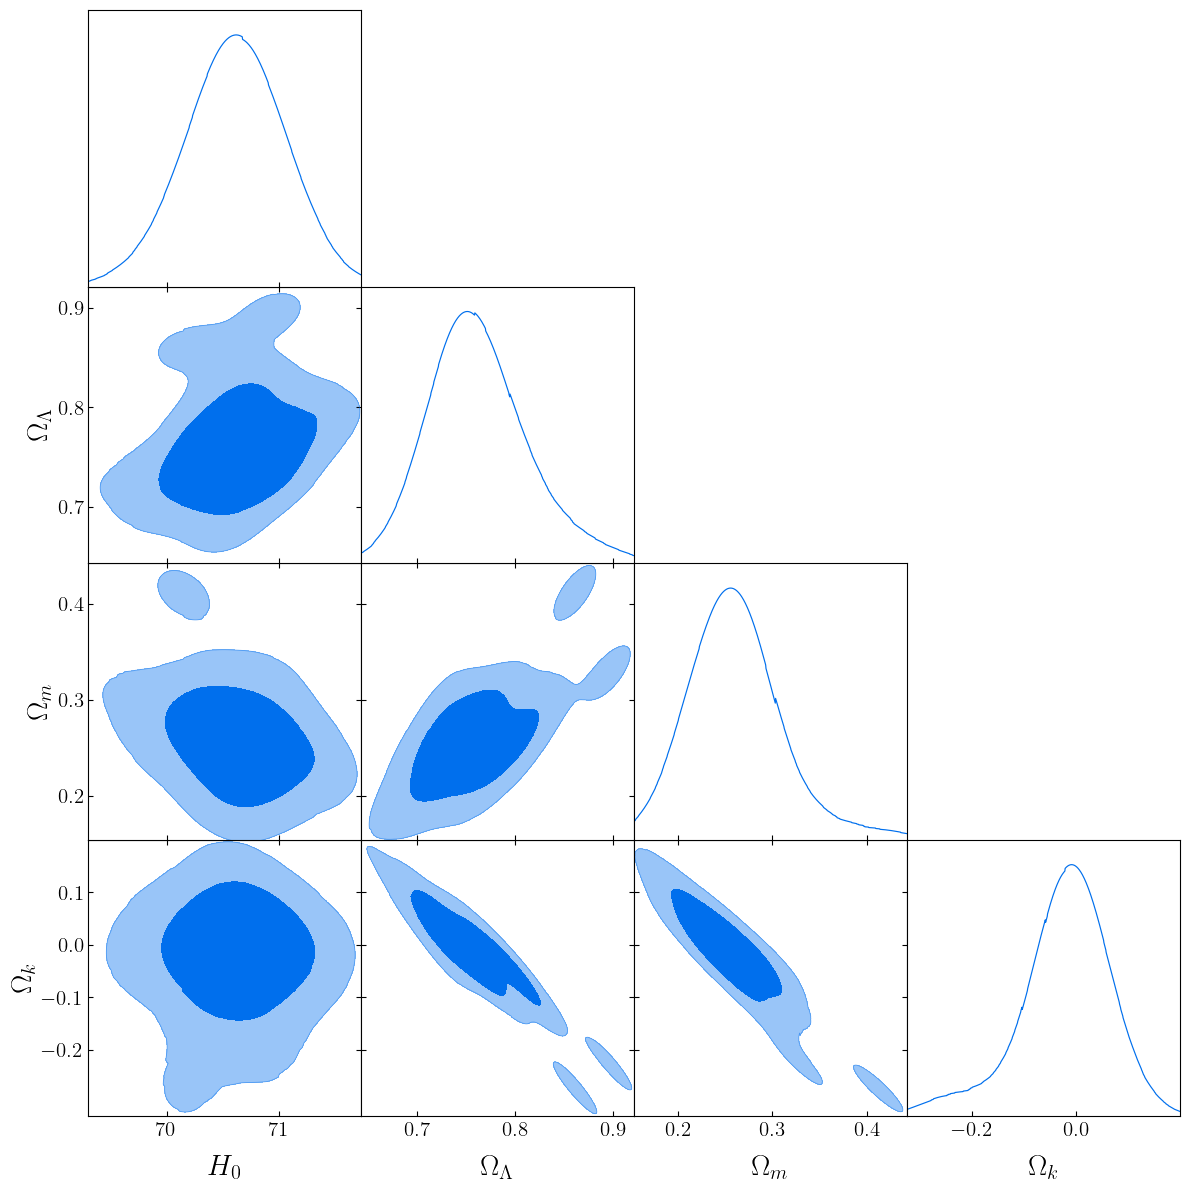

In [62]:
import getdist, IPython
from getdist import plots, MCSamples, loadMCSamples
#print('Version: ',getdist.__version__)
import numpy as np
import pylab
from random import random
from random import gauss
# If you want to use LaTeX in the labels. Not mandatory, but it looks nice ;)
pylab.rc('text',usetex=True) 

my_length = len(plist)
print(my_length)
par1, par2, par3 = [p[0] for p in plist], [p[1] for p in plist], [p[2] for p in plist]

par1 = np.array(par1)
par2 = np.array(par2)
par3 = np.array(par3)
par4 = 1 - par2 - par3


my_labels = [r'H_0', r'\Omega_{\Lambda}', r'\Omega_{m}', r'\Omega_{k}']
my_names = ['H0', 'OL', 'Om', 'Ok']
my_samples = np.array([par1, par2, par3, par4])

my_dim = 4

my_samples = np.transpose(np.reshape(my_samples,(my_dim,int(my_samples.size/my_dim))))
samples1 = MCSamples(samples = my_samples, labels = my_labels, names = my_names)

#Triangle corner plot
j = plots.getSubplotPlotter(subplot_size=3)
j.settings.axes_labelsize = 22
j.settings.axes_fontsize = 16
j.triangle_plot(samples1, filled = True)

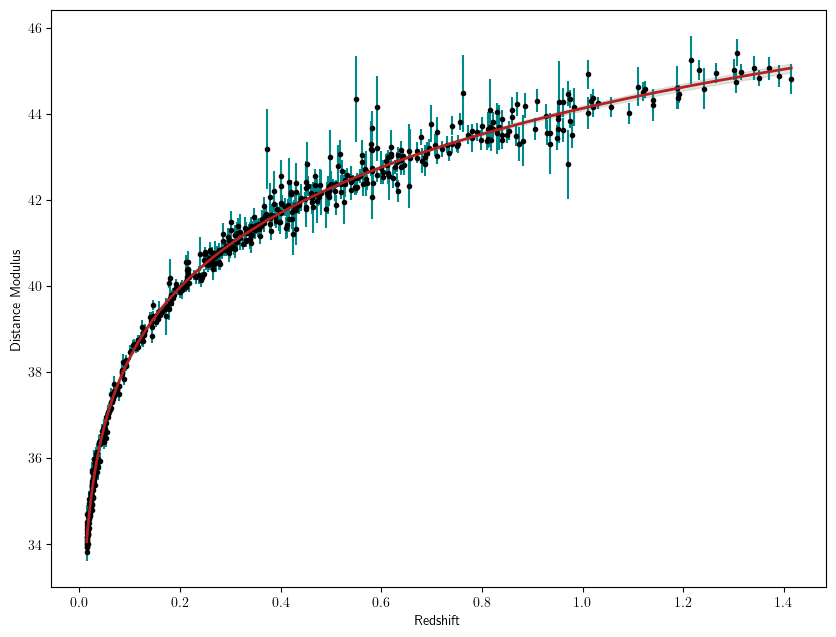

In [ ]:
# example of theoretical curves
SPEED_OF_LIGHT = 299792.458 # in km/s

# Still need to add Omega_k!
def theor_luminosity_distance(z, h, OmegaM, OmegaL):
    return 10.**6 * SPEED_OF_LIGHT / h * (1.+z) * \
    integrate.quad(lambda x: 1. / np.sqrt(OmegaM * (1.+x)**3 + OmegaL), 0., z)[0]

def theor_distance_modulus(z, h, OmegaM, OmegaL):
    return 5. * (-1. + np.log10(theor_luminosity_distance(z, h, OmegaM, OmegaL)))
                 

zsort = np.array(sorted(zs))
d_best_fit, d_min, d_max = [], [], []

# This code uses the list unpacking * operator. 
# This just passes each element of the list to the function as different arguments
best_model = dL_modulus(*best_params)

# all_values is a dictionary:
#   keys: every z from zsort
#   items: values generated at z by every model from the MCMC
all_values = {z:[dL_modulus(*theta)(z) for theta in plist] for z in zs}     

d_best_fit = [best_model(z) for z in zsort]
d_min = [min(all_values[z]) for z in zsort]     # minimum values corresponding to each z across all parameters from the MCMC
d_max = [max(all_values[z]) for z in zsort]     # same but max

plt.subplots(figsize=(10, 7.5))
plt.xlabel("Redshift")
plt.ylabel("Distance Modulus")

plt.errorbar(zs, dist_mod, yerr=err_dist_mod, fmt='o', color='black', ecolor='darkcyan', markersize=3)
plt.plot(zsort, d_best_fit, color='firebrick',linewidth=2., zorder=2.5)
plt.fill_between(zsort, d_min, d_max, color='grey', alpha=.2)
plt.show()